In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate,BatchNormalization
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, RepeatVector, Permute, merge
from keras.optimizers import Adam
from keras.models import Sequential
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
#google word2vec
from gensim.models import KeyedVectors as wv
word_vectors = wv.load_word2vec_format('./input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary = True)
EMBEDDING_DIM =300

##glove
# embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, './input/embeddings/glove.840B.300d/glove.840B.300d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
# EMBEDDING_DIM =300

# print('Found %s word vectors.' % len(embeddings_index))

In [32]:
df_train = pd.read_csv("./input/train.csv")
df_test = pd.read_csv("./input/test.csv")
print("Train shape : ",df_train.shape)
print("Test shape : ",df_test.shape)

df_train_pos = df_train[df_train['target']==1]
df_train_neg = df_train[df_train['target']==0].sample(len(df_train_pos)*5,random_state=1)
df_train = pd.concat([df_train_pos,df_train_neg])
df_train = df_train.sample(frac=1,random_state=1)
print("Train shape : ",df_train.shape)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

MAX_SEQUENCE_LENGTH=150


tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(df_train['question_text'])
sequences = tokenizer.texts_to_sequences(df_train['question_text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

train_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
train_Y = df_train['target']

sequences = tokenizer.texts_to_sequences(df_test['question_text'])
test_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
# test_Y = df_test['target']
# labels = to_categorical(np.asarray(labels))
# print('Shape of data tensor:', data.shape)
# print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
# indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
# data = data[indices]
# labels = labels[indices]
# nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

# x_train = data[:-nb_validation_samples]
# y_train = labels[:-nb_validation_samples]
# x_val = data[-nb_validation_samples:]
# y_val = labels[-nb_validation_samples:]

Train shape :  (1306122, 3)
Test shape :  (56370, 2)
Train shape :  (484860, 3)
Found 152399 unique tokens.


In [33]:

df_train.iloc[4]['question_text']

'Whats the percentage of people who actually live up to their marriage vows, including the "til death do us part" part?'

73.6223714061791
62.0
41.76537274429307
1017


(array([3.9506e+05, 8.0336e+04, 9.4590e+03, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([1.000e+00, 1.026e+02, 2.042e+02, 3.058e+02, 4.074e+02, 5.090e+02,
        6.106e+02, 7.122e+02, 8.138e+02, 9.154e+02, 1.017e+03]),
 <a list of 10 Patch objects>)

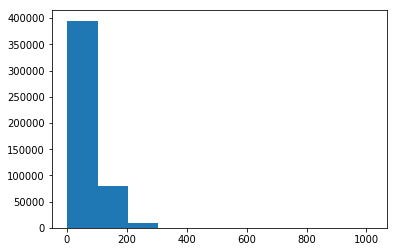

In [34]:
lengths = []
for sent in df_train['question_text']:
#     print(sent)
    lengths.append(len(sent))
#     if max(sent)>50:
#         print(sent)
print(np.mean(lengths))
print(np.median(lengths))
print(np.std(lengths))
print(np.max(lengths))
plt.hist(lengths,density=False)

In [35]:
#for google word2vec

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        word_vector = word_vectors[word]
#     if word_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = word_vector
    except KeyError:
        continue

In [36]:
# print(train_X_raw[0])
print(train_X.shape)
print(train_Y.shape)
# print(tokenizer.word_index)

(484860, 150)
(484860,)


In [37]:
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    # So we only measure F1 on the target y value:
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [38]:
##model definition
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))


# model.add(CuDNNLSTM(75, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Bidirectional(CuDNNLSTM(100, return_sequences=True), input_shape=(train_X.shape[1], EMBEDDING_DIM)))
# model.add(Bidirectional(CuDNNLSTM(100, return_sequences=False)))#, input_shape=(train_X.shape[1], EMBEDDING_DIM)))
# model.add(Attention(MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 300)          45720000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 150, 200)          321600    
_________________________________________________________________
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               3000100   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 49,041,801
Trainable params: 3,321,801
Non-trainable params: 45,720,000
_________________________________________________________________
None


In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])  

In [40]:
model.fit(train_X, train_Y, epochs=50,batch_size=500,validation_split=0.2)

Train on 387888 samples, validate on 96972 samples
Epoch 1/50
387888/387888 [==============================] - 64s 165us/step - loss: 0.2134 - acc: 0.9127 - f1: 0.7240 - val_loss: 0.1913 - val_acc: 0.9232 - val_f1: 0.7638
Epoch 2/50
387888/387888 [==============================] - 64s 165us/step - loss: 0.1875 - acc: 0.9242 - f1: 0.7666 - val_loss: 0.1822 - val_acc: 0.9282 - val_f1: 0.7678
Epoch 3/50
387888/387888 [==============================] - 65s 166us/step - loss: 0.1746 - acc: 0.9302 - f1: 0.7860 - val_loss: 0.1767 - val_acc: 0.9298 - val_f1: 0.7844
Epoch 4/50
387888/387888 [==============================] - 67s 172us/step - loss: 0.1631 - acc: 0.9348 - f1: 0.8011 - val_loss: 0.1756 - val_acc: 0.9307 - val_f1: 0.7806
Epoch 5/50
387888/387888 [==============================] - 67s 172us/step - loss: 0.1503 - acc: 0.9403 - f1: 0.8185 - val_loss: 0.1806 - val_acc: 0.9289 - val_f1: 0.7758
Epoch 6/50
387888/387888 [==============================] - 66s 171us/step - loss: 0.1357 - ac

387888/387888 [==============================] - 65s 169us/step - loss: 0.0050 - acc: 0.9984 - f1: 0.9952 - val_loss: 0.7127 - val_acc: 0.9166 - val_f1: 0.7452
Epoch 49/50
374500/387888 [===========================>..] - ETA: 2s - loss: 0.0039 - acc: 0.9987 - f1: 0.9961

KeyboardInterrupt: 

In [15]:
preds= model.predict(train_X,verbose=1)
# pred_cnn_val_y = model.predict([val_X], batch_size=1024, verbose=1)


242430/242430 [==============================] - 40s 165us/step


In [18]:
for thresh in np.arange(-0.20, 1, 0.05):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(train_Y, (preds>thresh).astype(int))))

F1 score at threshold -0.2 is 0.5
F1 score at threshold -0.15 is 0.5
F1 score at threshold -0.1 is 0.5
F1 score at threshold -0.05 is 0.5
F1 score at threshold -0.0 is 0.5006551699569726
F1 score at threshold 0.05 is 0.9538913433701808
F1 score at threshold 0.1 is 0.9588053741119749
F1 score at threshold 0.15 is 0.9608015640273705
F1 score at threshold 0.2 is 0.9622097119018885
F1 score at threshold 0.25 is 0.9630757144260041
F1 score at threshold 0.3 is 0.9636065150425176
F1 score at threshold 0.35 is 0.9639653505882643
F1 score at threshold 0.4 is 0.9641520716588683
F1 score at threshold 0.45 is 0.964307977164018
F1 score at threshold 0.5 is 0.9644417258274791
F1 score at threshold 0.55 is 0.9646491200940216
F1 score at threshold 0.6 is 0.9645400611848054
F1 score at threshold 0.65 is 0.964271098158368
F1 score at threshold 0.7 is 0.9639306803434937
F1 score at threshold 0.75 is 0.9634884906669319
F1 score at threshold 0.8 is 0.9628457710203242
F1 score at threshold 0.85 is 0.9619818

In [25]:
preds = model.predict_classes(test_X,verbose=1)
# print(metrics.f1_score(train_Y,preds))
print(sum(preds))

56370/56370 [==============================] - 9s 163us/step
[7259]


In [26]:
df_out = pd.DataFrame()
df_out["qid"] = df_test['qid']
df_out["predictions"] = preds
df_out.to_csv("sub.csv",index=False)

In [22]:
sum(preds)

array([81037], dtype=int32)

## Attention Layer

In [64]:
from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        #self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    #print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        #return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 150, 300)          30870600  
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 150, 280)          495040    
Total params: 31,365,640
Trainable params: 495,040
Non-trainable params: 30,870,600
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1)                 151       
_________________________________________________________________
activation_20 (Activation)   (None, 1)                 0         
_________________________________________________________________
repeat_vector_28 (RepeatVect (None, 150, 1)            0         
Total params: 151
Trainable params: 151
Non-trainable

/home/samarth/anaconda3/envs/tensorflow36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=150, units=1)`


TypeError: __init__() takes 1 positional argument but 2 were given

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten

model=Sequential()
model.add(Conv2D(10,(3,3)))
model.add(Conv2D(10,(3,3)))
model.add(Flatten())
model.add(Dense(20))
model.add(Dense(10))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# model.build()
# model.summary()

In [ ]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)

In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

In [ ]:
import string
letter_count = dict(zip(string.ascii_lowercase, [0]*26))

In [ ]:
{chr(i+96):i for i in range(1,27)}

In [ ]:
import keras.layers.`